In [1]:
!pip install wordcloud

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [3]:
train = pd.read_csv('output.csv')

In [4]:
print(train.shape)

(500, 5)


In [5]:

train.drop(columns=['Unnamed: 0'],inplace=True)
train.head()

,text,favourite_count,retweet_count,created_at
0,"When your employees are happy at work, they le...",1,0,2022-01-07 04:30:02+00:00
1,@LgbtqIndia @etimes How is this transgender?,2,0,2022-01-06 10:41:35+00:00
2,@LgbtqIndia @etimes He's playing the role of a...,1,0,2022-01-06 09:49:23+00:00
3,"Hiring LGBT+ Talent (LGBT+: Lesbian, Gay, Bise...",0,0,2022-01-06 07:58:24+00:00
4,...Transgender Persons (Protection of #Rights)...,1,0,2022-01-06 07:10:25+00:00


Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

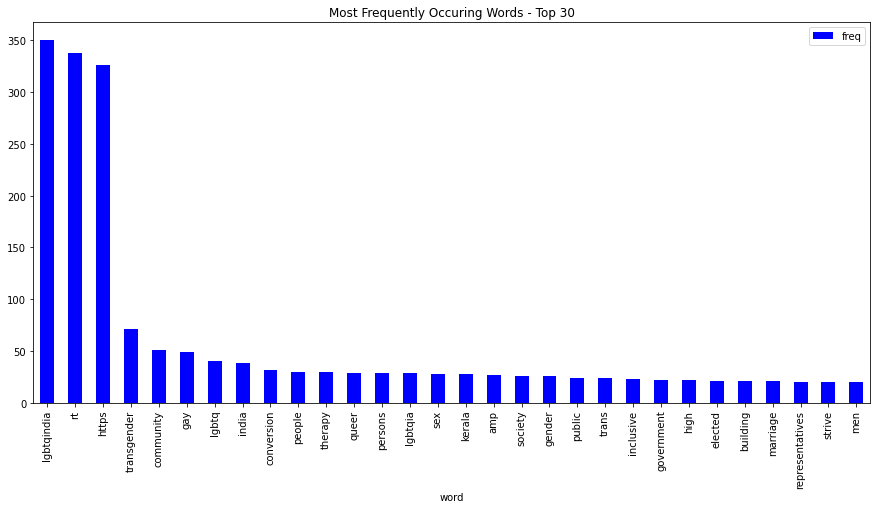

In [6]:
from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train.text)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

Text(0.5, 1.0, 'WordCloud - Vocabulary from Reviews')

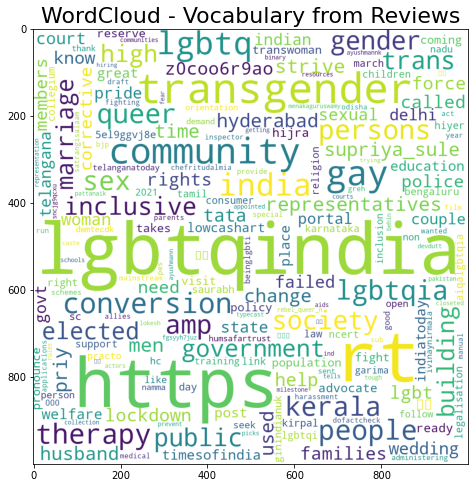

In [7]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from Reviews", fontsize = 22)

In [8]:
!pip install scipy

In [9]:
!pip3 install torch==1.10.1+cu102 torchvision==0.11.2+cu102 torchaudio===0.10.1+cu102 -f https://download.pytorch.org/whl/cu102/torch_stable.html
!pip install transformers requests beautifulsoup4 pandas numpy


Looking in links: https://download.pytorch.org/whl/cu102/torch_stable.html


In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re

In [11]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [12]:
tokens = tokenizer.encode('It was good but couldve been better. Great', return_tensors='pt')
result = model(tokens)
result.logits
int(torch.argmax(result.logits))+1

4

In [13]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [14]:
train['sentiment'] = train['text'].apply(lambda x: sentiment_score(x[:512]))

In [56]:
train.head()
#train.to_csv('outputWithSentiment.csv')

In [16]:
train[train['sentiment']==5].count()

text               127
favourite_count    127
retweet_count      127
created_at         127
sentiment          127
dtype: int64

In [17]:
train[train['sentiment']==4].count()

text               52
favourite_count    52
retweet_count      52
created_at         52
sentiment          52
dtype: int64

In [18]:
train[train['sentiment']==3].count()

text               34
favourite_count    34
retweet_count      34
created_at         34
sentiment          34
dtype: int64

In [19]:
train[train['sentiment']==2].count()

text               0
favourite_count    0
retweet_count      0
created_at         0
sentiment          0
dtype: int64

In [20]:
train[train['sentiment']==1].count()

text               287
favourite_count    287
retweet_count      287
created_at         287
sentiment          287
dtype: int64

In [21]:
train['text'].head()

0    When your employees are happy at work, they le...
1         @LgbtqIndia @etimes How is this transgender?
2    @LgbtqIndia @etimes He's playing the role of a...
3    Hiring LGBT+ Talent (LGBT+: Lesbian, Gay, Bise...
4    ...Transgender Persons (Protection of #Rights)...
Name: text, dtype: object

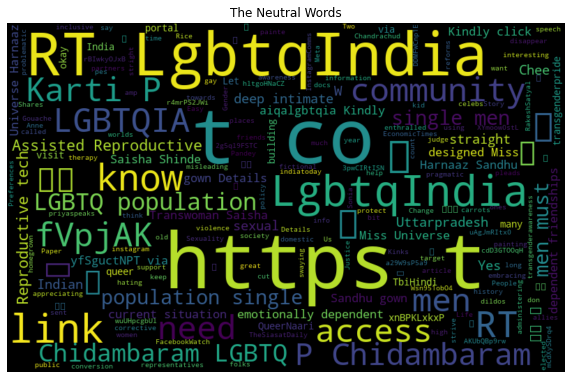

In [22]:
normal_words =' '.join([text for text in train['text'][train['sentiment'] == 3]])
normal_words.join([text for text in train['text'][train['sentiment'] == 4]])
normal_words.join([text for text in train['text'][train['sentiment'] == 5]])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Neutral Words')
plt.show()

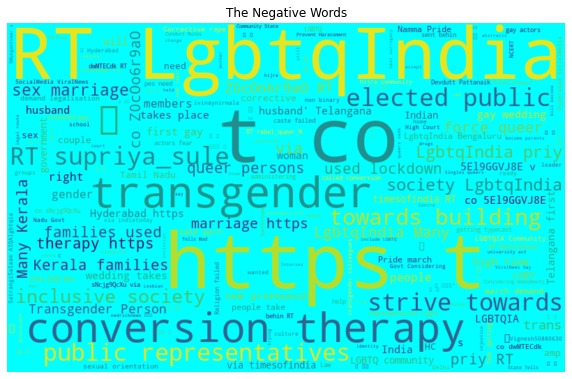

In [23]:
negative_words =' '.join([text for text in train['text'][train['sentiment'] == 1]])
#negative_words =' '.join([text for text in train['text'][train['sentiment'] == 2]])

wordcloud = WordCloud(background_color = 'cyan', width=800, height=500, random_state = 0, max_font_size = 110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Words')
plt.show()

In [24]:
import nltk
from sklearn.model_selection import train_test_split

In [25]:
# collecting the hashtags

def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [26]:
# extracting hashtags from non homophobic tweets
HT_regular = hashtag_extract(train['text'][train['sentiment'] == 5])

# extracting hashtags from homophobic tweets
HT_negative = hashtag_extract(train['text'][train['sentiment'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

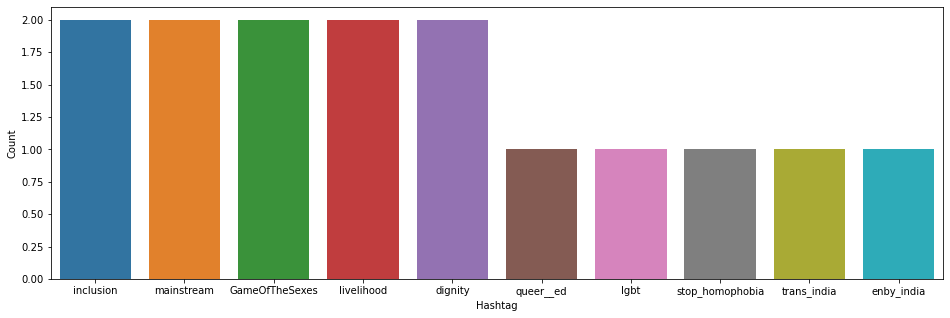

In [27]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

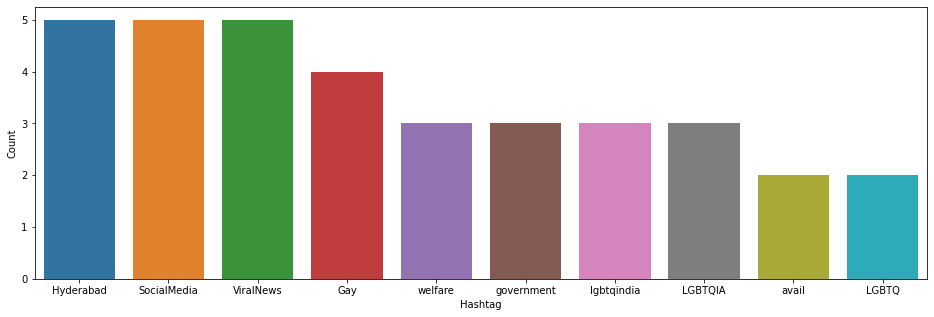

In [28]:
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [29]:
training_data = train.sample(frac=0.8, random_state=25)
testing_data = train.drop(training_data.index)

In [30]:
training_data.shape

(400, 5)

In [31]:
testing_data.shape

(100, 5)

In [32]:
testing_data.drop('sentiment', axis=1, inplace=True)

In [33]:
testing_data.head()

,text,favourite_count,retweet_count,created_at
2,@LgbtqIndia @etimes He's playing the role of a...,1,0,2022-01-06 09:49:23+00:00
14,@LgbtqIndia Oh god they are so lucky to have a...,1,0,2022-01-03 11:32:06+00:00
22,"RT @supriya_sule: We, more so as elected publi...",0,0,2022-01-01 12:42:19+00:00
36,"RT @supriya_sule: We, more so as elected publi...",0,0,2021-12-31 14:30:22+00:00
44,RT @cre8ives2dio: @cre8ives2dio presents the E...,0,0,2021-12-31 06:23:05+00:00


In [34]:
!pip install --upgrade gensim

Requirement already up-to-date: gensim in c:\users\nandita\anaconda3\lib\site-packages (4.1.2)


In [35]:
# tokenizing the words present in the training set
tokenized_tweet = training_data['text'].apply(lambda x: x.split()) 

# importing gensim
import gensim

# creating a word to vector model
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            vector_size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(training_data['text']), epochs=20)

(92490, 138700)

In [36]:
model_w2v.wv.most_similar(negative = "gay")

[('society.', -0.09959841519594193),
 ('Help', -0.10880620032548904),
 ('them', -0.12006313353776932),
 ('an', -0.12854687869548798),
 ('cover', -0.13399818539619446),
 ('HC', -0.13912680745124817),
 ('community', -0.1407771110534668),
 ('#mainstream', -0.14407919347286224),
 ('know', -0.15556369721889496),
 ('members', -0.1556229442358017)]

In [37]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import TaggedDocument

C:\Users\nandita\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [38]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(TaggedDocument(s, ["tweet_" + str(i)]))
    return output

# label all the tweets
labeled_tweets = add_label(tokenized_tweet)

labeled_tweets[:6]

[TaggedDocument(words=['RT', '@LgbtqIndia:', 'Gouri', 'Kishan,', 'Anagha', 'shine', 'in', 'Tamil', 'music', 'video', 'rooting', 'for', 'LGBT', 'cause.', 'https://t.co/xPpNUoX7lv', 'via', '@dt_next'], tags=['tweet_411']),
 TaggedDocument(words=['RT', '@LgbtqIndia:', 'Stay-At-Home', 'Dad', 'to', 'Makeup', 'Tutorials', '&amp;', 'Kolam:', '6', 'Men', 'Breaking', '‘Mard’', 'Stereotypes', 'https://t.co/QwvAF51mNG'], tags=['tweet_380']),
 TaggedDocument(words=['.@BJP4Maharashtra', 'leader', '@SMungantiwar', 's', 'objection', 'to', 'provisions', 'to', 'include', 'LGBTQ', 'community', 'in', 'university', 'act', 'amend…', 'https://t.co/y43vlYH4JM'], tags=['tweet_38']),
 TaggedDocument(words=['Hiring', 'LGBT+', 'Talent', '-', 'PAN', 'India', 'Experience:', '0', 'to', '15', 'yrs', 'Multiple', 'Industries', 'View', 'relevant', 'opportunities', 'at:…', 'https://t.co/DBHSYAtx6T'], tags=['tweet_254']),
 TaggedDocument(words=['RT', '@TOIPlus:', 'Stealing', 'non-binary,', 'genderfluid', 'fashion', 'styl

In [39]:
# removing unwanted patterns from the data

import re
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nandita\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
training_data['text'].shape

(400,)

In [41]:
#training_data.drop('Unnamed: 0',axis=1,inplace=True)

KeyError: "['Unnamed: 0'] not found in axis"

In [42]:
training_data.columns

Index(['text', 'favourite_count', 'retweet_count', 'created_at', 'sentiment'], dtype='object')

In [43]:
new_index=[i for i in range(400)]
training_data=training_data.reindex(new_index)
training_data.head()

,text,favourite_count,retweet_count,created_at,sentiment
0,"When your employees are happy at work, they le...",1.0,0.0,2022-01-07 04:30:02+00:00,5.0
1,@LgbtqIndia @etimes How is this transgender?,2.0,0.0,2022-01-06 10:41:35+00:00,1.0
2,NaN,NaN,NaN,NaN,NaN
3,"Hiring LGBT+ Talent (LGBT+: Lesbian, Gay, Bise...",0.0,0.0,2022-01-06 07:58:24+00:00,1.0
4,...Transgender Persons (Protection of #Rights)...,1.0,0.0,2022-01-06 07:10:25+00:00,1.0


In [44]:
training_data.fillna('0',inplace=True)
training_data['text'][2]

'0'

In [45]:
#for i in range(len(training_data['text'])):
#    if training_data['text'][i]==0:
#        training_data['text'][i]='0' 

In [46]:
train_corpus = []

for i in range(len(training_data['text'])):
    #print(training_data['text'][i])
    review = re.sub('[^a-zA-Z]', ' ', training_data['text'][i])
    #print(review)
    review = review.lower()
    review = review.split()
  
    ps = PorterStemmer()
  
  # stemming
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
  
  # joining them back with space
    review = ' '.join(review)
    
    train_corpus.append(review)
    

In [47]:
#testing_data.drop('Unnamed: 0',axis=1,inplace=True)

new_index=[i for i in range(100)]
testing_data=testing_data.reindex(new_index)
testing_data.head()

testing_data.fillna('0',inplace=True)
testing_data.head()

,text,favourite_count,retweet_count,created_at
0,0,0,0,0
1,0,0,0,0
2,@LgbtqIndia @etimes He's playing the role of a...,1,0,2022-01-06 09:49:23+00:00
3,0,0,0,0
4,0,0,0,0


In [48]:
test_corpus = []

for i in range(0, len(testing_data['text'])):
    review = re.sub('[^a-zA-Z]', ' ', testing_data['text'][i])
    review = review.lower()
    review = review.split()

    ps = PorterStemmer()

      # stemming
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]

      # joining them back with space
    review = ' '.join(review)
    test_corpus.append(review)

In [49]:
test_corpus

['',
 '',
 'lgbtqindia etim play role launda naach artist transgend person',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'lgbtqindia oh god lucki support famili famili readi face let http co xecmemri',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'rt supriya sule elect public repres strive toward build inclus societi lgbtqindia priy',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'rt supriya sule elect public repres strive toward build inclus societi lgbtqindia priy',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'rt cre ive dio cre ive dio present exclus poster film releas th januari premier youtub',
 '',
 'kinda ppl still exist govern orinam pride lgbtqindia http co pmxtnbjn',
 'queerphob rant dumb idiot deserv utter condemn fact interrupt hav http co shevyow eu',
 '',
 '',
 'rt lgbtqindia black glove writer sex worker game call red light red light http co lwt f lope',
 'rt lgbtqindia straight talk latheesh lakshman work mock malayali societi fals sens superior heteronor

In [57]:
# creating bag of words

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 100)
x = cv.fit_transform(train_corpus).toarray()
y = training_data.iloc[:, 1]
y=y.astype('int')
print(x.shape)
print(y.shape)

(400, 100)
(400,)


In [58]:
# creating bag of words

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 100)
x_test = cv.fit_transform(test_corpus).toarray()

print(x_test.shape)

(100, 100)


In [59]:
# splitting the training data into train and valid sets



x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.25, random_state = 42)

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(300, 100)
(100, 100)
(300,)
(100,)


In [60]:
# standardization

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)
x_test = sc.transform(x_test)

In [61]:
y_train

247    0
110    0
16     0
66     0
153    0
      ..
71     0
106    0
270    0
348    0
102    0
Name: favourite_count, Length: 300, dtype: int32

In [63]:
#RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = RandomForestClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_valid, y_pred,average='micro'))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

Training Accuracy : 0.9666666666666667
Validation Accuracy : 0.82
F1 score : 0.82
[[80  3  1  0  0  0  0  2]
 [ 4  2  0  0  0  0  0  1]
 [ 2  0  0  0  0  0  0  1]
 [ 1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1]
 [ 1  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]


In [64]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred,average='micro'))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

Training Accuracy : 0.9666666666666667
Validation Accuracy : 0.85
f1 score : 0.85
[[83  1  2  0  0  0  0]
 [ 5  2  0  0  0  0  0]
 [ 2  1  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]]


C:\Users\nandita\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [66]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred,average='micro'))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

Training Accuracy : 0.9666666666666667
Validation Accuracy : 0.86
f1 score : 0.8599999999999999
[[83  2  1  0  0  0  0]
 [ 3  2  2  0  0  0  0]
 [ 2  0  1  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0]
 [ 0  1  0  0  0  0  0]]


In [67]:
from sklearn.svm import SVC

model = SVC()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred,average='micro'))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

Training Accuracy : 0.88
Validation Accuracy : 0.86
f1 score : 0.8599999999999999
[[85  1  0  0  0  0  0]
 [ 6  1  0  0  0  0  0]
 [ 3  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]]


In [74]:
!pip install xgboost

In [77]:
from xgboost import XGBClassifier

model = XGBClassifier()#use_label_encoder=False
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred,average='micro'))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

[14:06:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy : 0.94
Validation Accuracy : 0.85
f1 score : 0.85
[[84  2  0  0  0  0  0]
 [ 6  0  1  0  0  0  0]
 [ 2  0  1  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0]]


In [78]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(x_train, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(x_test)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred,average='micro'))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

Training Accuracy : 0.94
Validation Accuracy : 0.85
f1 score : 0.17
[[17  0  0 69  0  0  0]
 [ 0  0  0  7  0  0  0]
 [ 0  0  0  3  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0  0  0  1  0  0  0]]
